In [1]:
#подгружаем библиотеки
import pandas as pd
from scipy.stats import binned_statistic_2d
from datetime import datetime
import numpy as np
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#Скачивающая функция
def download_file(url):
    local_filename = url.split('/')[-1]
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk:
                f.write(chunk)
    f.close()
    return local_filename

In [3]:
#Скачиваем один файл
for year in [str(i) for i in range(2016, 2017)]:
    for month in [str(i)[1:] for i in range(105, 106)]:
        url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_'+year+'-'+month+'.csv'
        print(url)

https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2016-05.csv


In [4]:
%%time
data = pd.read_csv('yellow_tripdata_2016-05.csv')

CPU times: user 47.6 s, sys: 4.48 s, total: 52.1 s
Wall time: 1min 9s


In [5]:
#Взглянем на данные
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [6]:
data.shape

(11836853, 19)

In [7]:
#Эти данные мы не используем
data = data.drop([u'VendorID', u'RatecodeID', u'store_and_fwd_flag',
       u'dropoff_longitude', u'dropoff_latitude', u'payment_type',
       u'fare_amount', u'extra', u'mta_tax', u'tip_amount', u'tolls_amount',
       u'improvement_surcharge', u'total_amount'], 1)

In [8]:
#Границы
xmin = -74.25559
xmax = -73.70001
ymin = 40.49612
ymax = 40.91553

In [9]:
%%time
#Удаляем поездки с:
data = data[data.tpep_pickup_datetime!=data.tpep_dropoff_datetime]#нулевой длительностью
data = data[data.passenger_count!=0]#нулевым количеством пассажиров
data = data[data.trip_distance!=0]#нулевым расстоянием поездки по счётчику
data = data[data.pickup_longitude>=xmin]#координатами начала, не попадающими в прямоугольник Нью-Йорка
data = data[data.pickup_longitude<=xmax]
data = data[data.pickup_latitude>=ymin]
data = data[data.pickup_latitude<=ymax]

CPU times: user 7.52 s, sys: 316 ms, total: 7.84 s
Wall time: 7.86 s


In [10]:
#Эти данные мы больше не используем
data = data.drop([u'tpep_dropoff_datetime',
       u'passenger_count', u'trip_distance'], 1)

In [11]:
#Тут мы меняем границы, потому как функция binned_statistic_2d считает и то, что не попадает в range, как отдельные bins.
#A их номера при переводе из двумерного формата предстают в виде (bins+2)*binnumber[0]+binnumber[1]
xmin = -74.2444784
xmax = -73.7111216
ymin = 40.5045082
ymax = 40.9071418

In [12]:
binned = binned_statistic_2d(x=data.pickup_longitude.values, y=data.pickup_latitude.values, values=data.tpep_pickup_datetime.values, bins=48, statistic='count', range=[[xmin, xmax], [ymin, ymax]], expand_binnumbers=False)

In [13]:
data['bin'] = (binned.binnumber+1)#Нумерация территорий начинается с 1

In [14]:
data.tail(1)#Проверим, что идентификаторы, которые мы присваиваем ячейкам, соответствуют приложенному файлу

,tpep_pickup_datetime,pickup_longitude,pickup_latitude,bin
11836841,2016-05-19 03:29:16,-73.948959,40.586658,1361


In [15]:
regions = pd.read_csv('regions.csv', sep = ';')
regions.head(1361).tail(1)#Да, мы попадаем в нужные координаты

,region,west,east,south,north
1360,1361,-73.955577,-73.944465,40.580002,40.58839


In [16]:
data = data.drop([u'pickup_longitude', u'pickup_latitude'], 1)#Эти данные мы больше не используем
data.tpep_pickup_datetime = pd.to_datetime(data.tpep_pickup_datetime)#Переводим в формат datetime

In [17]:
d = data.tpep_pickup_datetime[0]
y = d.year
m = d.month
time_edges = []
for day in range(1, d.days_in_month+1):
    for hour in range(24):
        time_edges.append(datetime(y, m, day, hour))
if m<12:
    time_edges.append(datetime(y, m+1, 1, 0))
else:
    time_edges.append(datetime(y+1, 1, 1, 0))

In [18]:
%%time
#Агрегируем данные за май 2016 года по часам и областям
final_data = []
for i, t0 in enumerate(time_edges[:-1]):
    t1 = time_edges[i+1]
    hour_data = data[data.tpep_pickup_datetime<t1][data.tpep_pickup_datetime>=t0]
    hour_data = pd.DataFrame(hour_data.bin.value_counts()).sort_index()
    z = pd.DataFrame(np.zeros(2500, dtype=int), columns=['n'], index=range(1, 2501))
    for i in hour_data.index:
        z.n[i] =  hour_data.bin[i]
    z['time']=2500*[t0]
    z['place']=z.index
    final_data = final_data+list(z.as_matrix())
    print(str(t0))
final_data = pd.DataFrame(final_data, columns=z.columns)
final_data.to_csv('n_'+str(y)+'-'+str(m)+'.csv')

/home/uzd/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


2016-05-01 00:00:00
2016-05-01 01:00:00
2016-05-01 02:00:00
2016-05-01 03:00:00
2016-05-01 04:00:00
2016-05-01 05:00:00
2016-05-01 06:00:00
2016-05-01 07:00:00
2016-05-01 08:00:00
2016-05-01 09:00:00
2016-05-01 10:00:00
2016-05-01 11:00:00
2016-05-01 12:00:00
2016-05-01 13:00:00
2016-05-01 14:00:00
2016-05-01 15:00:00
2016-05-01 16:00:00
2016-05-01 17:00:00
2016-05-01 18:00:00
2016-05-01 19:00:00
2016-05-01 20:00:00
2016-05-01 21:00:00
2016-05-01 22:00:00
2016-05-01 23:00:00
2016-05-02 00:00:00
2016-05-02 01:00:00
2016-05-02 02:00:00
2016-05-02 03:00:00
2016-05-02 04:00:00
2016-05-02 05:00:00
2016-05-02 06:00:00
2016-05-02 07:00:00
2016-05-02 08:00:00
2016-05-02 09:00:00
2016-05-02 10:00:00
2016-05-02 11:00:00
2016-05-02 12:00:00
2016-05-02 13:00:00
2016-05-02 14:00:00
2016-05-02 15:00:00
2016-05-02 16:00:00
2016-05-02 17:00:00
2016-05-02 18:00:00
2016-05-02 19:00:00
2016-05-02 20:00:00
2016-05-02 21:00:00
2016-05-02 22:00:00
2016-05-02 23:00:00
2016-05-03 00:00:00
2016-05-03 01:00:00


In [19]:
#Выводим первые строки полученной таблицы с указанием времени(time), идентификатора зоны (place) и количества поездок (n).
final_data.head()

,n,time,place
0,0,2016-05-01,1
1,0,2016-05-01,2
2,0,2016-05-01,3
3,0,2016-05-01,4
4,0,2016-05-01,5


In [20]:
#Выводим первые строки полученной таблицы с ненулевым количеством поездок (n).
final_data[final_data['n']!=0].head()

,n,time,place
1014,1,2016-05-01,1015
1016,1,2016-05-01,1017
1028,3,2016-05-01,1029
1029,1,2016-05-01,1030
1032,4,2016-05-01,1033


In [21]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860000 entries, 0 to 1859999
Data columns (total 3 columns):
n        int64
time     datetime64[ns]
place    int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 42.6 MB


In [22]:
#Координаты Empire State Building
Latitude = 40.748817
Longitude = -73.985428

In [23]:
#Выясним номер интересующей нас территории
regions[regions.west<Longitude][regions.east>Longitude][regions.south<Latitude][regions.north>Latitude]

/home/uzd/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


,region,west,east,south,north
1230,1231,-73.988912,-73.9778,40.747766,40.756154


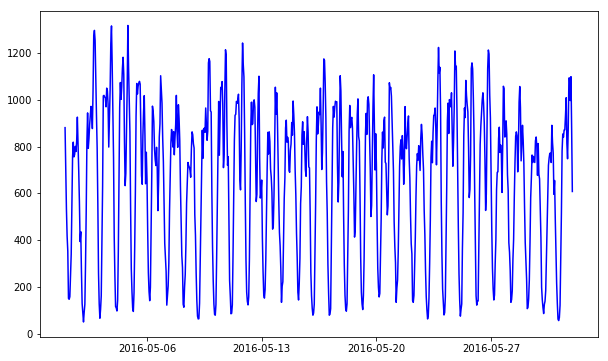

In [24]:
#Строим график количества поездок жёлтого такси из ячейки, содержащей Empire State Building
plt.figure(figsize=(10, 6))
Empire_State_Building = final_data[final_data.place==1231]
plt.plot_date(Empire_State_Building.time, Empire_State_Building.n, 'b-')
plt.show()

In [25]:
#Посчитаем, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.
final_data[final_data.n==0].shape[0]

1718238